# Классификация грибов методами ML

Это интересный проект по применению процесса исследовательского анализа данных (EDA) и многочисленных алгоритмов классификации к [набору данных о грибах из Kaggle](https://www.kaggle.com/datasets/uciml/mushroom-classification), который состоит из 8143 данных наблюдений за грибами и 23 признаков, описывающих два класса грибов - съедобные и ядовитые. Я провожу предварительный анализ данных в наборе данных и применяю многочисленные алгоритмы классификации, чтобы выбрать наилучшую модель для определения того, является ли гриб съедобным или ядовитым.

In [9]:
# Импортируем необходимые библиотеки
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import graphviz 
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn import tree
from sklearn.tree import export_graphviz
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay, roc_auc_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
import xgboost as xgb
from sklearn.metrics import RocCurveDisplay
from xgboost import XGBRegressor
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

Мы начнем с определения некоторых функций, которые пригодятся позже.

In [10]:
def model_predictions(model, X_train, X_test, y_train, y_test, df, model_name):
    """Функция для сопоставления модели с обучающими данными и генерации прогнозов. 
    Другая функция, performance_metrics_recorder, вызывается для записи результатов
    прогнозов во фрейм данных для последующего анализа.

    Аргументы:
        model (instance): Экземпляр модели классификатора.
        X_train (pd.DataFrame): Dataframe, содержащий обучающие данные для всех столбцов, кроме целевого.
        X_test (pd.DataFrame): Dataframe, содержащий тестовые данные для всех столбцов, кроме целевого.
        y_train (pd.DataFrame): Dataframe, содержащий обучающие данные для целевого столбца.
        y_test (pd.DataFrame): Dataframe, содержащий тестовые данные для целевого столбца.
        df (pd.DataFrame): Dataframe, к которому будут привязаны оценки модели.
        model_name (str): Label для названия модели.

    Возвращается:
        df: Фрейм данных с фиксированными оценками модели.
        model_confusion: матрица путаницы для прогнозов.
    """
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    df, model_confusion = performance_metrics_recorder(predictions, y_test, df, model_name)

    return (model, df, model_confusion)

def performance_metrics_recorder(predictions, y_test, df, model_name):
    """Вспомогательная функция для записи оценок для прогнозов модели во фрейм данных.

    Аргументы:
        predictions (pd.DataFrame): Dataframe для прогнозов, сгенерированных классификатором.
        y_test (pd.DataFrame): Dataframe, содержащий данные тестирования для целевого столбца.
        df (pd.DataFrame): Dataframe, к которому будут привязаны оценки модели.
        имя_модели (str): Label для названия модели.
    
    Возвращается:
        df: Dataframe с фиксированными оценками модели.
        model_confusion: матрица путаницы для прогнозов.
    """
    model_accuracy_score = accuracy_score(y_test, predictions)
    model_precision_score = precision_score(y_test, predictions)
    model_recall_score = recall_score(y_test, predictions)
    model_f1_score = f1_score(y_test, predictions)
    model_roc_auc = roc_auc_score(y_test, predictions)
    model_confusion = confusion_matrix(y_test, predictions)

    df.loc[len(df)] = [model_name,model_accuracy_score,model_precision_score,model_recall_score,model_f1_score,model_roc_auc]

    return(df, model_confusion)

def feature_importance_visualizer(X, model, label, color=None, grid=None):
    """Вспомогательная функция для визуализации важности объекта.

    Аргументы:
        X (pd.DataFrame): Dataframe, содержащий все столбцы, кроме целевого.
        model (экземпляр): Экземпляр модели классификатора.
        label (str): Метка для названия модели.
        color (str, необязательно): Цвет столбцов на графике. По умолчанию - Нет.
        сетка (bool, необязательно): Следует ли включать линии сетки или нет. По умолчанию - нет.
    """
    features_list = X.columns.values
    feature_importance = model.feature_importances_
    sorted_idx = np.argsort(feature_importance)

    plt.figure()
    plt.barh(range(len(sorted_idx)),feature_importance[sorted_idx], align='center', color=color)
    plt.yticks(range(len(sorted_idx)), features_list[sorted_idx])
    plt.xlabel('Importance')
    plt.title("Feature Importances According to " + label + " Classifier")
    if grid is True:
        plt.grid(alpha=0.5)
    plt.show()
    
def feature_importance_visualizer_for_nonstandards(X, model, label, color, grid=None):
    """Вспомогательная функция для визуализации важности признаков для алгоритмов, которые не поддерживают модель.метод feature_importances_.

    Аргументы:
        X (pd.DataFrame): Фрейм данных, содержащий все столбцы, кроме целевого.
        model (instance): Экземпляр модели классификатора.
        label (str): Метка для названия модели.
        color (str, необязательно): Цвет столбцов на графике. По умолчанию нет.
        сетка (bool, необязательно): следует ли включать линии сетки или нет. По умолчанию - Нет.
    """
    try:
        importance = model.coef_[0]
    except:
        importance = model.coef_

    feature_importances = pd.DataFrame({
        'feature':X.columns.to_list(), 
        'importance':importance.tolist()
    }).sort_values('importance',ascending=True)

    plt.barh(feature_importances['feature'],feature_importances['importance'], align='center', color=color)
    plt.xlabel('Importance')
    plt.title("Feature Importances According to " + label + " Classifier")
    if grid is True:
        plt.grid(alpha=0.5)
    plt.show()

## Шаг первый: Поиск, анализ и предварительная обработка данных

В этом разделе мы исследуем исходный набор данных и очищаем его для последующего использования.

In [12]:
# чтение необработанного файла CSV-данных
df = pd.read_csv("mushrooms.csv")
df.head()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g


In [13]:
# Проверка пропущенных значений
df.isnull().sum()

class                       0
cap-shape                   0
cap-surface                 0
cap-color                   0
bruises                     0
odor                        0
gill-attachment             0
gill-spacing                0
gill-size                   0
gill-color                  0
stalk-shape                 0
stalk-root                  0
stalk-surface-above-ring    0
stalk-surface-below-ring    0
stalk-color-above-ring      0
stalk-color-below-ring      0
veil-type                   0
veil-color                  0
ring-number                 0
ring-type                   0
spore-print-color           0
population                  0
habitat                     0
dtype: int64

Мы обнаружили, что это редкий идеальный набор данных без значений NA или null.

In [14]:
# получение формы набора данных
df.shape

(8124, 23)

Мы также отмечаем, что в нем 23 столбца (т.е. объекты) и 8124 строки данных.

In [15]:
# получение информации о столбцах df
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8124 entries, 0 to 8123
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   class                     8124 non-null   object
 1   cap-shape                 8124 non-null   object
 2   cap-surface               8124 non-null   object
 3   cap-color                 8124 non-null   object
 4   bruises                   8124 non-null   object
 5   odor                      8124 non-null   object
 6   gill-attachment           8124 non-null   object
 7   gill-spacing              8124 non-null   object
 8   gill-size                 8124 non-null   object
 9   gill-color                8124 non-null   object
 10  stalk-shape               8124 non-null   object
 11  stalk-root                8124 non-null   object
 12  stalk-surface-above-ring  8124 non-null   object
 13  stalk-surface-below-ring  8124 non-null   object
 14  stalk-color-above-ring  

In [16]:
# получение статистических описаний df
df.describe()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
count,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,...,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124
unique,2,6,4,10,2,9,2,2,2,12,...,4,9,9,1,4,3,5,9,6,7
top,e,x,y,n,f,n,f,c,b,b,...,s,w,w,p,w,o,p,w,v,d
freq,4208,3656,3244,2284,4748,3528,7914,6812,5612,1728,...,4936,4464,4384,8124,7924,7488,3968,2388,4040,3148


In [ ]:
# получение уникальных значений из каждого столбца, чтобы мы знали, какие значения преобразовать в числовые
for col in df.columns:
    print(col, df[col].unique())

class ['p' 'e']
cap-shape ['x' 'b' 's' 'f' 'k' 'c']
cap-surface ['s' 'y' 'f' 'g']
cap-color ['n' 'y' 'w' 'g' 'e' 'p' 'b' 'u' 'c' 'r']
bruises ['t' 'f']
odor ['p' 'a' 'l' 'n' 'f' 'c' 'y' 's' 'm']
gill-attachment ['f' 'a']
gill-spacing ['c' 'w']
gill-size ['n' 'b']
gill-color ['k' 'n' 'g' 'p' 'w' 'h' 'u' 'e' 'b' 'r' 'y' 'o']
stalk-shape ['e' 't']
stalk-root ['e' 'c' 'b' 'r' '?']
stalk-surface-above-ring ['s' 'f' 'k' 'y']
stalk-surface-below-ring ['s' 'f' 'y' 'k']
stalk-color-above-ring ['w' 'g' 'p' 'n' 'b' 'e' 'o' 'c' 'y']
stalk-color-below-ring ['w' 'p' 'g' 'b' 'n' 'e' 'y' 'o' 'c']
veil-type ['p']
veil-color ['w' 'n' 'o' 'y']
ring-number ['o' 't' 'n']
ring-type ['p' 'e' 'l' 'f' 'n']
spore-print-color ['k' 'n' 'u' 'h' 'w' 'r' 'o' 'y' 'b']
population ['s' 'n' 'a' 'v' 'y' 'c']
habitat ['u' 'g' 'm' 'd' 'p' 'w' 'l']


Мы обратили внимание на названия столбцов, их типы данных и количество уникальных значений для каждого объекта. Мы видим, что все они являются объектными типами данных, т.е. строками, и имеют несколько различных значений. Нам нужно преобразовать эти строки в числовой тип данных. Давайте для простоты выполним кодирование меток для этих объектов.

In [18]:
# создание копии исходного dataframe
df2 = df.copy()

In [19]:
# выполнение кодирования меток для каждого из 23 объектов
for col in df2.columns:
    le = LabelEncoder()
    le.fit(df2[col])
    df2[col] = le.transform(df2[col])
    if col == 'class':
        le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
        print(le_name_mapping)

{'e': np.int64(0), 'p': np.int64(1)}


Итак, мы узнаем, что метод LabelEncoding присвоил классу "съедобный" значение 0, а "ядовитый" - 1. Полезно знать на будущее!

In [21]:
# посмотрим на количество для каждого класса
counts = df2['class'].value_counts()
print(counts)

class
0    4208
1    3916
Name: count, dtype: int64


In [22]:
# проверка соотношения классов "e" и "p"
total_counts = 4208 + 3916
print((4208/total_counts)*100) # class 0 = 'e'
print((3916/total_counts)*100) # class 1 = 'p'

51.7971442639094
48.20285573609059


Данные кажутся сбалансированными - соотношение съедобных и ядовитых грибов составляет примерно 50 на 50, что указывает на то, что наши данные сбалансированы. Поэтому мы не будем применять здесь методы балансировки, подобные SMOTE.

In [24]:
# проверка dataframe, закодированного метками
df2.head()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,1,5,2,4,1,6,1,0,1,4,...,2,7,7,0,2,1,4,2,3,5
1,0,5,2,9,1,0,1,0,0,4,...,2,7,7,0,2,1,4,3,2,1
2,0,0,2,8,1,3,1,0,0,5,...,2,7,7,0,2,1,4,3,2,3
3,1,5,3,8,1,6,1,0,1,5,...,2,7,7,0,2,1,4,2,3,5
4,0,5,2,3,0,5,1,1,0,4,...,2,7,7,0,2,1,0,3,0,1


Теперь, когда dataframe представлен в числовом формате, мы можем выполнить дополнительный предварительный анализ данных (EDA). Давайте начнем с визуализации взаимосвязи объектов друг с другом.

In [25]:
# получение корреляционной матрицы матрицы
corr = df2.corr()
corr.style.background_gradient('coolwarm')

c:\Users\Mikhail.Kalmykov\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\io\formats\style.py:3807: RuntimeWarning: All-NaN slice encountered
  smin = np.nanmin(gmap) if vmin is None else vmin
c:\Users\Mikhail.Kalmykov\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\io\formats\style.py:3808: RuntimeWarning: All-NaN slice encountered
  smax = np.nanmax(gmap) if vmax is None else vmax


,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,stalk-root,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
class,1.000000,0.052951,0.178446,-0.031384,-0.501530,-0.093552,0.129200,-0.348387,0.540024,-0.530566,-0.102019,-0.379361,-0.334593,-0.298801,-0.154003,-0.146730,nan,0.145142,-0.214366,-0.411771,0.171961,0.298686,0.217179
cap-shape,0.052951,1.000000,-0.050454,-0.048203,-0.035374,-0.021935,0.078865,0.013196,0.054050,-0.006039,0.063794,0.030191,-0.030417,-0.032591,-0.031659,-0.030390,nan,0.072560,-0.106534,-0.025457,-0.073416,0.063413,-0.042221
cap-surface,0.178446,-0.050454,1.000000,-0.019402,0.070228,0.045233,-0.034180,-0.282306,0.208100,-0.161017,-0.014123,-0.126245,0.089090,0.107965,0.066050,0.068885,nan,-0.016603,-0.026147,-0.106407,0.230364,0.021555,0.163887
cap-color,-0.031384,-0.048203,-0.019402,1.000000,-0.000764,-0.387121,0.041436,0.144259,-0.169464,0.084659,-0.456496,0.321274,-0.060837,-0.047710,0.002364,0.008057,nan,0.036130,-0.005822,0.162513,-0.293523,-0.144770,0.033925
bruises,-0.501530,-0.035374,0.070228,-0.000764,1.000000,-0.061825,0.137359,-0.299473,-0.369596,0.527120,0.099364,0.244188,0.460824,0.458983,0.083538,0.092874,nan,0.119770,0.056788,0.692973,-0.285008,0.088137,-0.075095
odor,-0.093552,-0.021935,0.045233,-0.387121,-0.061825,1.000000,-0.059590,0.063936,0.310495,-0.129213,0.459766,-0.205215,0.118617,0.061820,0.174532,0.169407,nan,-0.057747,0.111905,-0.281387,0.469055,-0.043623,-0.026610
gill-attachment,0.129200,0.078865,-0.034180,0.041436,0.137359,-0.059590,1.000000,0.071489,0.108984,-0.128567,0.186485,0.144063,-0.088916,-0.116177,0.099299,0.097160,nan,0.897518,0.093236,-0.146689,-0.029524,0.165575,-0.030304
gill-spacing,-0.348387,0.013196,-0.282306,0.144259,-0.299473,0.063936,0.071489,1.000000,-0.108333,0.100193,0.080895,0.350548,-0.212359,-0.213775,0.274574,0.253505,nan,0.073363,0.243014,-0.195897,0.047323,-0.529253,-0.154680
gill-size,0.540024,0.054050,0.208100,-0.169464,-0.369596,0.310495,0.108984,-0.108333,1.000000,-0.516736,0.214576,-0.344345,0.056310,0.010894,0.296548,0.278708,nan,0.103809,-0.171362,-0.460872,0.622991,0.147682,0.161418
gill-color,-0.530566,-0.006039,-0.161017,0.084659,0.527120,-0.129213,-0.128567,0.100193,-0.516736,1.000000,-0.175699,0.315080,0.224287,0.257224,-0.058299,-0.074781,nan,-0.097583,0.096054,0.629398,-0.416135,-0.034090,-0.202972


In [26]:
# проверка столбца veil-type, который содержит nan
df2['veil-type'].unique()

array([0])

Похоже, что значение "nan" в корреляционной матрице для столбца veil-type связано с тем, что метка для этого столбца была закодирована как 0. Оглядываясь на исходные данные, кажется, что существует только одно значение для veil-type, "p", которое было закодировано как 0. Позже это может стать проблемой, а может и не стать, покажет только время.

In [ ]:
# стандартизация данных
df3 = df2.copy()
scaler = StandardScaler()
df3 = scaler.fit_transform(df3)
df3 = pd.DataFrame(df3, columns=df2.columns)

In [28]:
# получение корреляционной матрицы из стандартизированной матрицы
corr = df3.corr()
corr.style.background_gradient('coolwarm')

c:\Users\Mikhail.Kalmykov\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\io\formats\style.py:3807: RuntimeWarning: All-NaN slice encountered
  smin = np.nanmin(gmap) if vmin is None else vmin
c:\Users\Mikhail.Kalmykov\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\io\formats\style.py:3808: RuntimeWarning: All-NaN slice encountered
  smax = np.nanmax(gmap) if vmax is None else vmax


,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,stalk-root,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
class,1.000000,0.052951,0.178446,-0.031384,-0.501530,-0.093552,0.129200,-0.348387,0.540024,-0.530566,-0.102019,-0.379361,-0.334593,-0.298801,-0.154003,-0.146730,nan,0.145142,-0.214366,-0.411771,0.171961,0.298686,0.217179
cap-shape,0.052951,1.000000,-0.050454,-0.048203,-0.035374,-0.021935,0.078865,0.013196,0.054050,-0.006039,0.063794,0.030191,-0.030417,-0.032591,-0.031659,-0.030390,nan,0.072560,-0.106534,-0.025457,-0.073416,0.063413,-0.042221
cap-surface,0.178446,-0.050454,1.000000,-0.019402,0.070228,0.045233,-0.034180,-0.282306,0.208100,-0.161017,-0.014123,-0.126245,0.089090,0.107965,0.066050,0.068885,nan,-0.016603,-0.026147,-0.106407,0.230364,0.021555,0.163887
cap-color,-0.031384,-0.048203,-0.019402,1.000000,-0.000764,-0.387121,0.041436,0.144259,-0.169464,0.084659,-0.456496,0.321274,-0.060837,-0.047710,0.002364,0.008057,nan,0.036130,-0.005822,0.162513,-0.293523,-0.144770,0.033925
bruises,-0.501530,-0.035374,0.070228,-0.000764,1.000000,-0.061825,0.137359,-0.299473,-0.369596,0.527120,0.099364,0.244188,0.460824,0.458983,0.083538,0.092874,nan,0.119770,0.056788,0.692973,-0.285008,0.088137,-0.075095
odor,-0.093552,-0.021935,0.045233,-0.387121,-0.061825,1.000000,-0.059590,0.063936,0.310495,-0.129213,0.459766,-0.205215,0.118617,0.061820,0.174532,0.169407,nan,-0.057747,0.111905,-0.281387,0.469055,-0.043623,-0.026610
gill-attachment,0.129200,0.078865,-0.034180,0.041436,0.137359,-0.059590,1.000000,0.071489,0.108984,-0.128567,0.186485,0.144063,-0.088916,-0.116177,0.099299,0.097160,nan,0.897518,0.093236,-0.146689,-0.029524,0.165575,-0.030304
gill-spacing,-0.348387,0.013196,-0.282306,0.144259,-0.299473,0.063936,0.071489,1.000000,-0.108333,0.100193,0.080895,0.350548,-0.212359,-0.213775,0.274574,0.253505,nan,0.073363,0.243014,-0.195897,0.047323,-0.529253,-0.154680
gill-size,0.540024,0.054050,0.208100,-0.169464,-0.369596,0.310495,0.108984,-0.108333,1.000000,-0.516736,0.214576,-0.344345,0.056310,0.010894,0.296548,0.278708,nan,0.103809,-0.171362,-0.460872,0.622991,0.147682,0.161418
gill-color,-0.530566,-0.006039,-0.161017,0.084659,0.527120,-0.129213,-0.128567,0.100193,-0.516736,1.000000,-0.175699,0.315080,0.224287,0.257224,-0.058299,-0.074781,nan,-0.097583,0.096054,0.629398,-0.416135,-0.034090,-0.202972


## Шаг второй: Классификационные модели

Мы начинаем с разделения набора данных на два отдельных набора: X - который содержит все объекты, за исключением целевого объекта ("class"), и Y - который содержит только целевой объект ("class"), и создаем разбиения на обучающие и тестовые с соотношением 80/20%.

In [29]:
# разделение набора данных
X = df2.drop(['class'],axis=1)
Y = df2['class']

In [30]:
# создаем разделение на обучение и тест, используя 80% данных для обучения и 20% для тестирования.
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 42)

In [31]:
# определение нескольких пустых dfs для записи показателей из каждой модели и этапа анализа.
column_names = ["method","accuracy","precision","recall","f1","roc_auc"]
performance_metrics = pd.DataFrame(columns=column_names)

Теперь мы воспользуемся некоторыми моделями и классифицируем данные.

In [32]:
# Наивный Байес
nb = GaussianNB()
nb, performance_metrics, nb_confusion = model_predictions(nb, X_train, X_test, y_train, y_test, performance_metrics, "Naive Bayes")

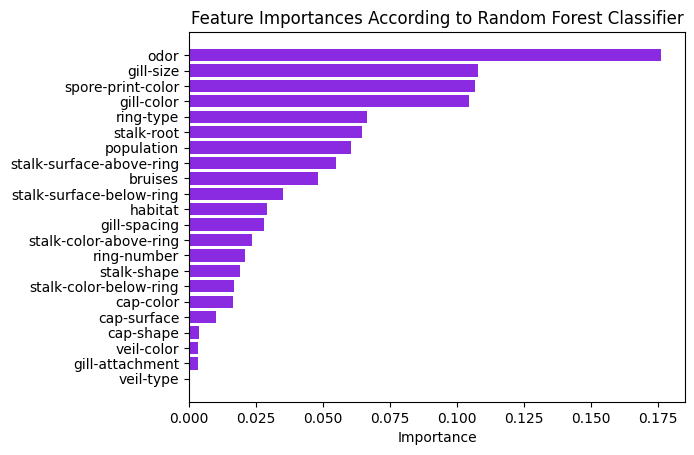

In [33]:
# Случайный лес
label = "Random Forest"
rf = RandomForestClassifier(random_state=42)
rf, performance_metrics, rf_confusion = model_predictions(rf, X_train, X_test, y_train, y_test, performance_metrics, label)
feature_importance_visualizer(X, rf, label, color="blueviolet")

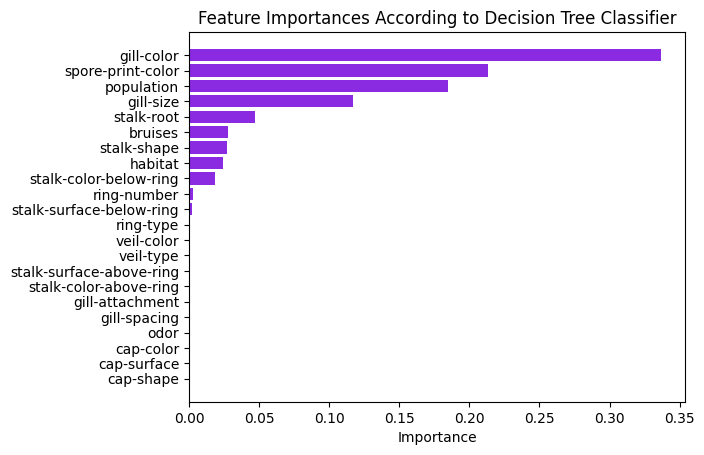

In [34]:
# Дерево решений
label = "Decision Tree"
dt = tree.DecisionTreeClassifier()
dt, performance_metrics, dt_confusion = model_predictions(dt, X_train, X_test, y_train, y_test, performance_metrics, label)
feature_importance_visualizer(X, dt, label, color="blueviolet")

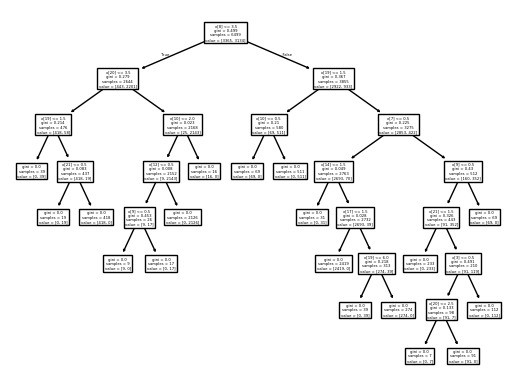

In [35]:
# также строим дерево решений
tree.plot_tree(dt);

c:\Users\Mikhail.Kalmykov\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


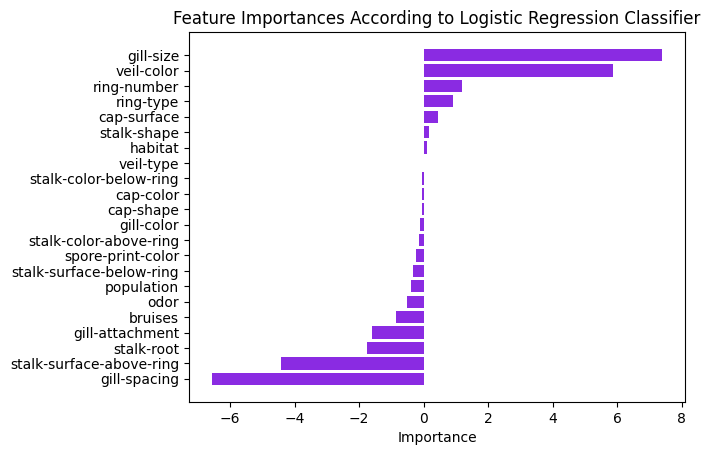

In [36]:
# Логистическая регрессия
label = "Logistic Regression"
lr = LogisticRegression()
lr, performance_metrics, lr_confusion = model_predictions(lr, X_train, X_test, y_train, y_test, performance_metrics, label)
feature_importance_visualizer_for_nonstandards(X, lr, label, color="blueviolet");

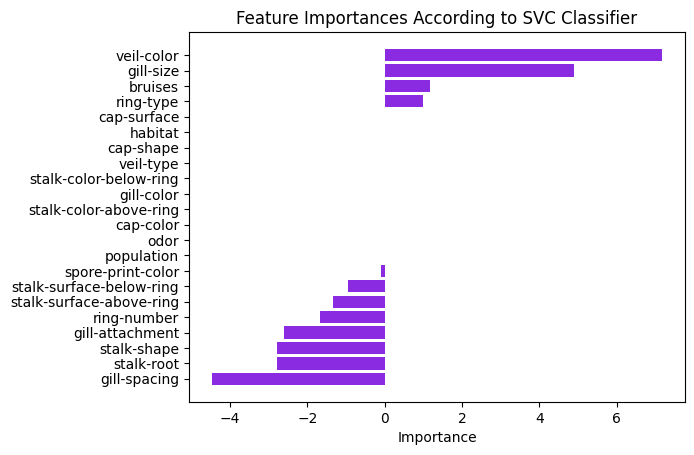

In [37]:
# Классификатор опорных векторов
label = "SVC"
svc = SVC(kernel='linear')
svc, performance_metrics, svc_confusion = model_predictions(svc, X_train, X_test, y_train, y_test, performance_metrics, label)
feature_importance_visualizer_for_nonstandards(X, svc, label, color="blueviolet")

In [38]:
# Метод k ближайших соседей
label = "KNN"
knn = KNeighborsClassifier()
knn, performance_metrics, knn_confusion = model_predictions(knn, X_train, X_test, y_train, y_test, performance_metrics, label)
# функция важности признака не определена для алгоритма KNN

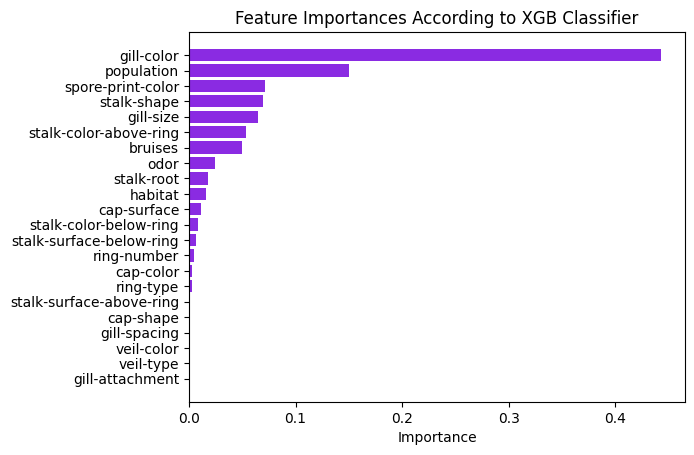

In [39]:
# XGBoost
label = "XGB"
xgboost = xgb.XGBClassifier()
xgboost, performance_metrics, xgb_confusion = model_predictions(xgboost, X_train, X_test, y_train, y_test, performance_metrics, label)
feature_importance_visualizer(X, xgboost, label, color="blueviolet")

In [40]:
# # проверка ataframe метрик
performance_metrics

,method,accuracy,precision,recall,f1,roc_auc
0,Naive Bayes,0.921846,0.909887,0.929668,0.919671,0.922129
1,Random Forest,1.000000,1.000000,1.000000,1.000000,1.000000
2,Decision Tree,1.000000,1.000000,1.000000,1.000000,1.000000
3,Logistic Regression,0.947077,0.942748,0.947570,0.945153,0.947095
4,SVC,0.972923,0.981723,0.961637,0.971576,0.972515
5,KNN,0.996308,0.992386,1.000000,0.996178,0.996441
6,XGB,1.000000,1.000000,1.000000,1.000000,1.000000


C:\Users\Mikhail.Kalmykov\AppData\Local\Temp\ipykernel_4480\4285751722.py:28: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


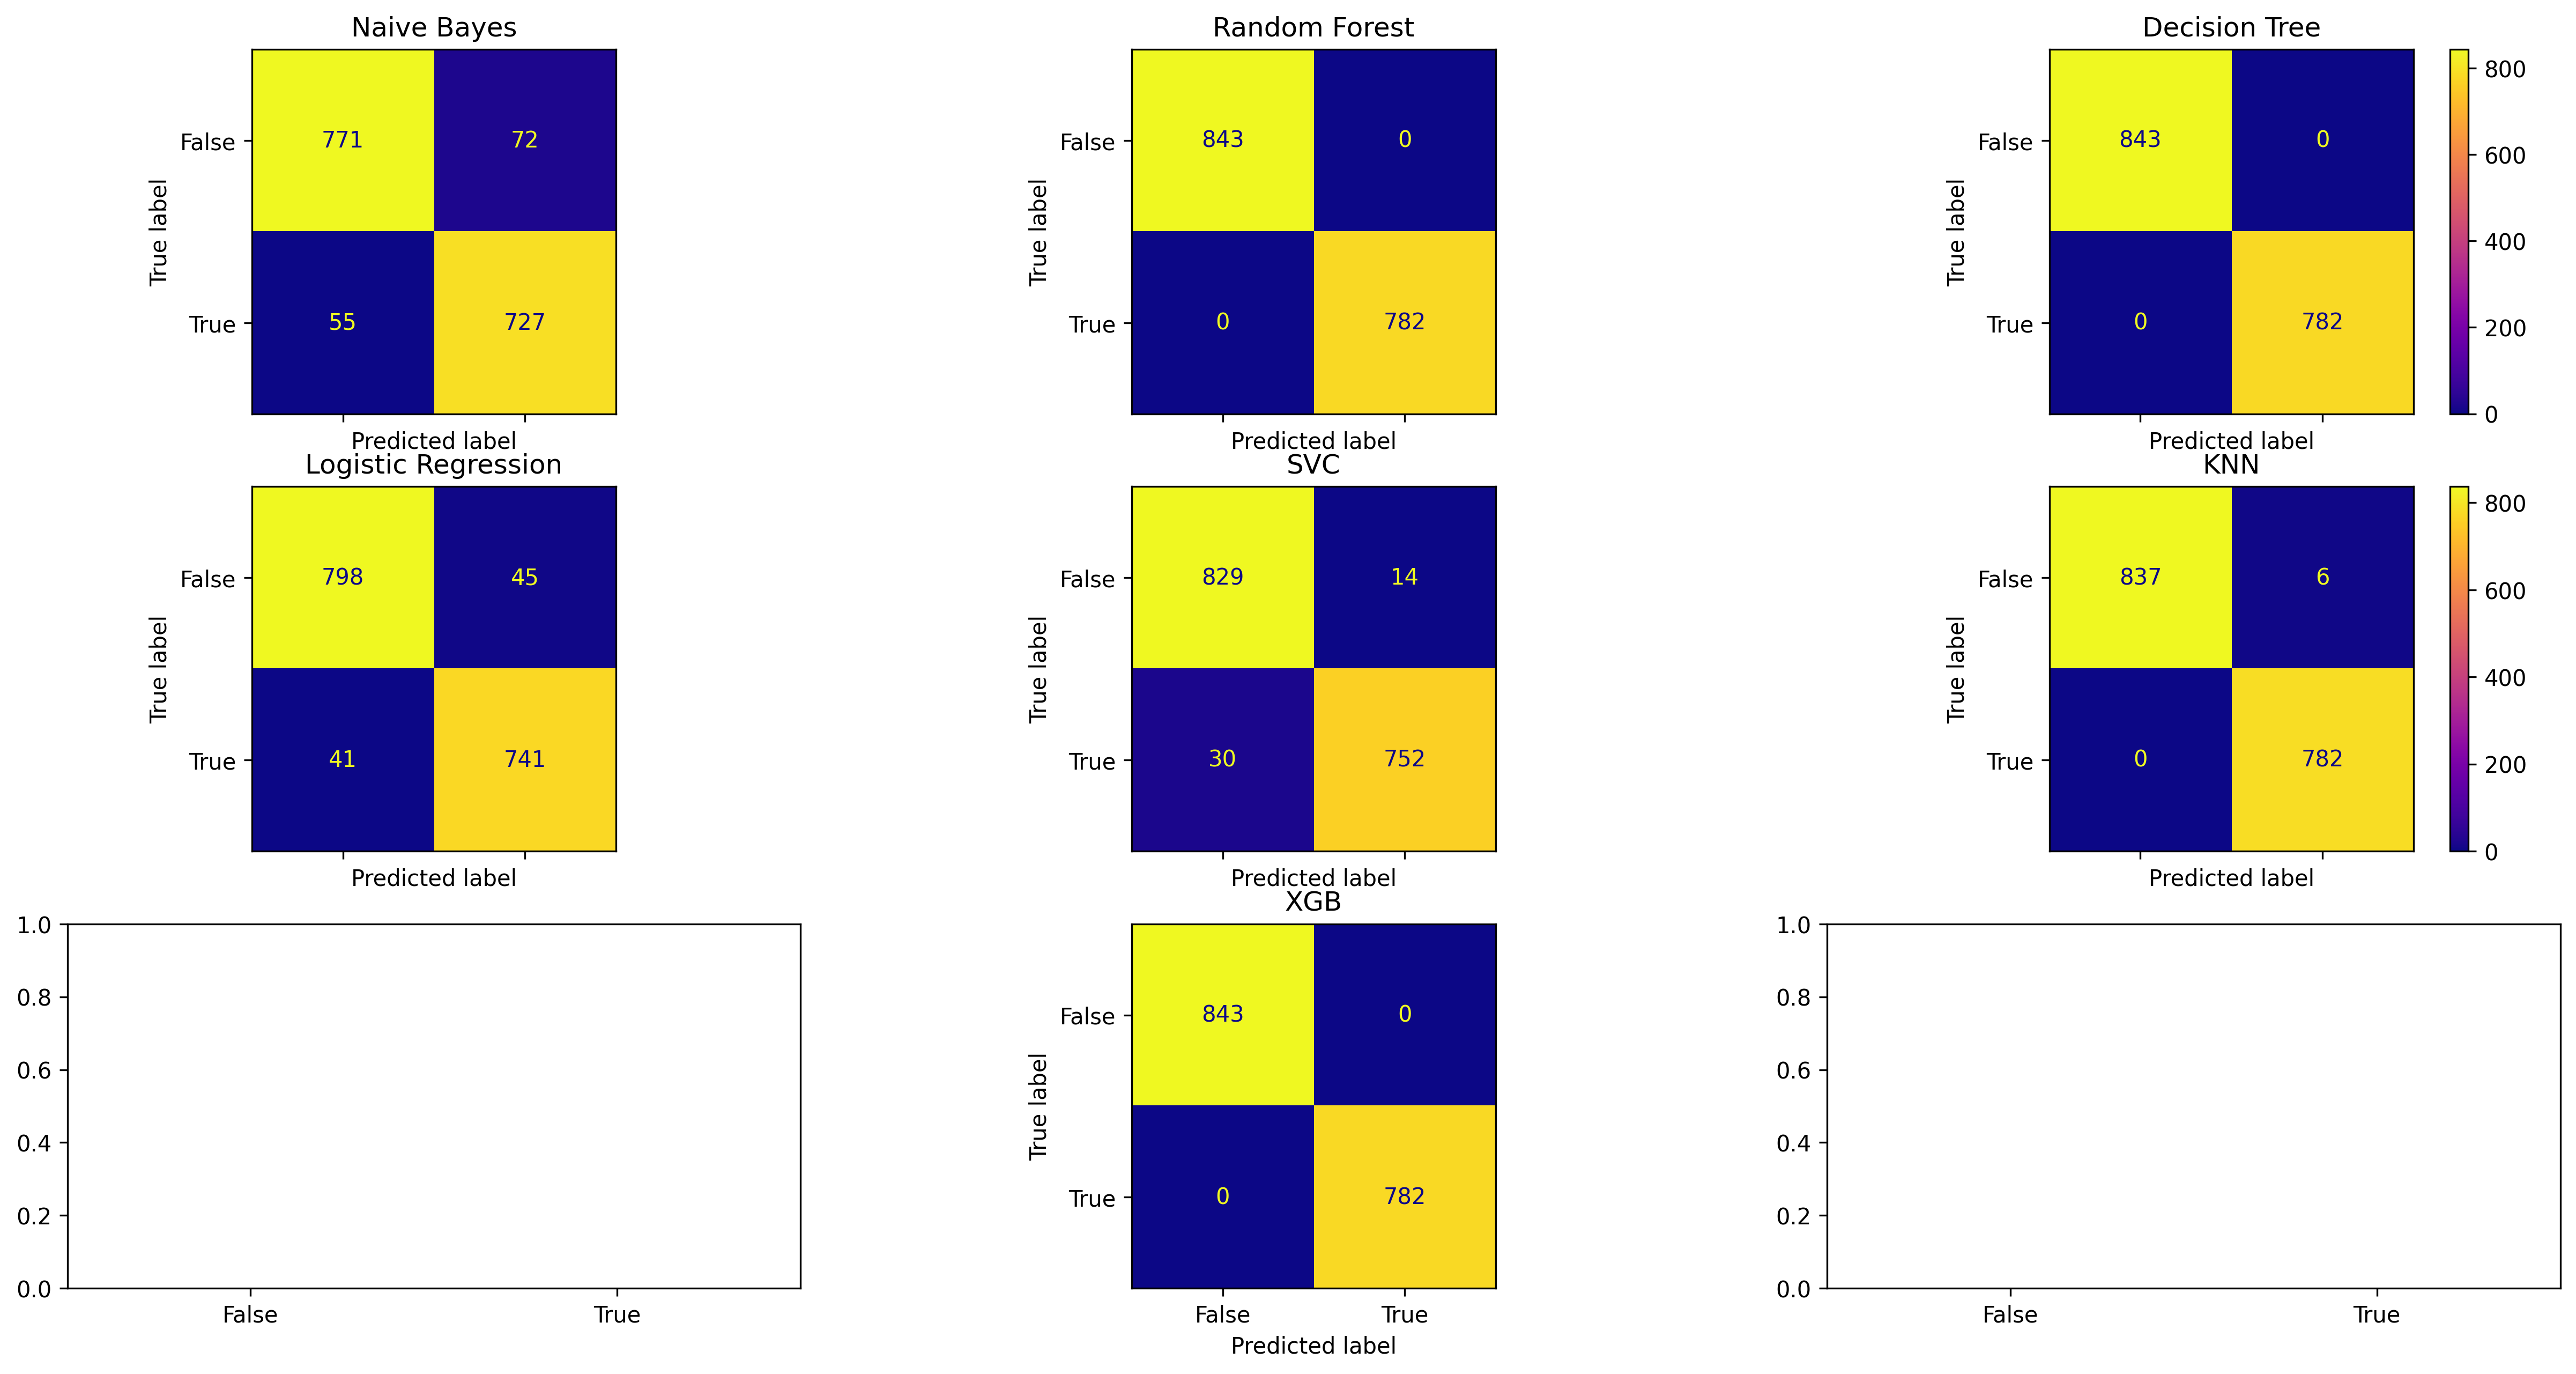

In [ ]:
# сравнение матриц путаницы для данного этапа анализа
x_labels = performance_metrics['method']
indices = np.arange(len(x_labels))

fig, ax = plt.subplots(3,3,sharex=True, sharey=False, figsize=(20, 10), dpi=300)

# первый ряд
ax[0, 0].set_title(x_labels[0])
ax[0, 1].set_title(x_labels[1])
ax[0, 2].set_title(x_labels[2])
# второй ряд
ax[1, 0].set_title(x_labels[3])
ax[1, 1].set_title(x_labels[4])
ax[1, 2].set_title(x_labels[5])
# третий ряд
ax[2, 1].set_title(x_labels[6])

# первый ряд
ConfusionMatrixDisplay(nb_confusion,display_labels=[False,True]).plot(ax=ax[0, 0],cmap='plasma',colorbar=False)
ConfusionMatrixDisplay(rf_confusion,display_labels=[False,True]).plot(ax=ax[0, 1],cmap='plasma',colorbar=False)
ConfusionMatrixDisplay(dt_confusion,display_labels=[False,True]).plot(ax=ax[0, 2],cmap='plasma',colorbar=True)
# второй ряд
ConfusionMatrixDisplay(lr_confusion,display_labels=[False,True]).plot(ax=ax[1, 0],cmap='plasma',colorbar=False)
ConfusionMatrixDisplay(svc_confusion,display_labels=[False,True]).plot(ax=ax[1, 1],cmap='plasma',colorbar=False)
ConfusionMatrixDisplay(knn_confusion,display_labels=[False,True]).plot(ax=ax[1, 2],cmap='plasma',colorbar=True)
# третий ряд
ConfusionMatrixDisplay(xgb_confusion,display_labels=[False,True]).plot(ax=ax[2, 1],cmap='plasma',colorbar=False)
fig.show()

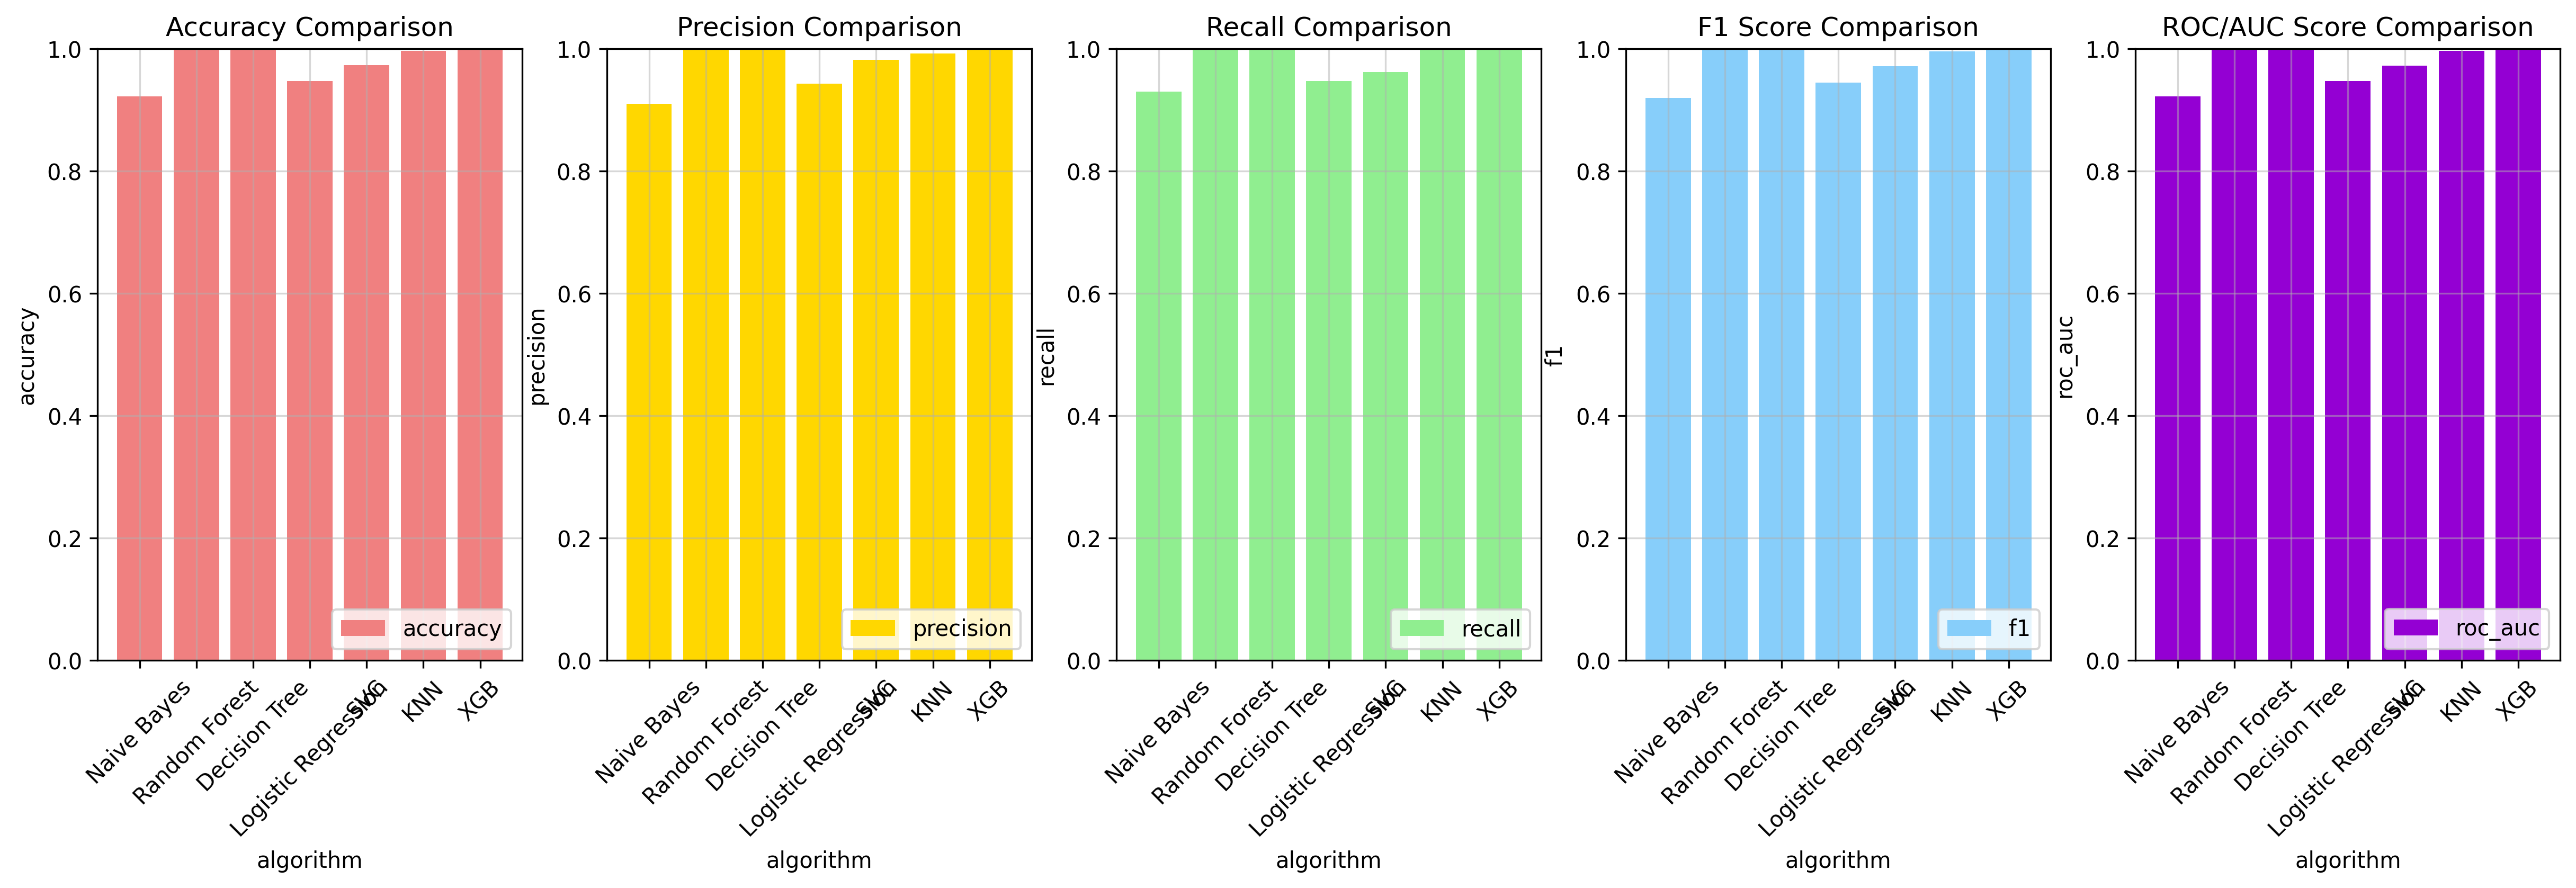

In [43]:
# сравнение всех показателей
fig, ax = plt.subplots(1, 5, sharex=True, sharey=False, figsize=(20, 5), dpi=300)
x_labels = performance_metrics['method']
indices = np.arange(len(x_labels))
width = 0.3

#row=0, col=0
ax[0].bar(indices,performance_metrics['accuracy'],color="lightcoral",alpha=1,label="accuracy") 
ax[0].grid(True,alpha=0.5)
ax[0].set_ylim(0,1)
ax[0].set_xlabel("algorithm")
ax[0].set_ylabel("accuracy")
ax[0].set_title("Accuracy Comparison")
ax[0].legend(loc='lower right')
ax[0].set_xticks(indices, x_labels, rotation=45)

#row=0, col=1
ax[1].bar(indices,performance_metrics['precision'],color="gold",alpha=1,label="precision") 
ax[1].grid(True,alpha=0.5)
ax[1].set_ylim(0,1)
ax[1].set_xlabel("algorithm")
ax[1].set_ylabel("precision")
ax[1].set_title("Precision Comparison")
ax[1].legend(loc='lower right')
ax[1].set_xticks(indices, x_labels, rotation=45)

#row=0, col=2
ax[2].bar(indices,performance_metrics['recall'],color="lightgreen",alpha=1,label="recall") 
ax[2].grid(True,alpha=0.5)
ax[2].set_ylim(0,1)
ax[2].set_xlabel("algorithm")
ax[2].set_ylabel("recall")
ax[2].set_title("Recall Comparison")
ax[2].legend(loc='lower right')
ax[2].set_xticks(indices, x_labels, rotation=45)

#row=0, col=3
ax[3].bar(indices,performance_metrics['f1'],color="lightskyblue",alpha=1,label="f1") 
ax[3].grid(True,alpha=0.5)
ax[3].set_ylim(0,1)
ax[3].set_xlabel("algorithm")
ax[3].set_ylabel("f1")
ax[3].set_title("F1 Score Comparison")
ax[3].legend(loc='lower right')
ax[3].set_xticks(indices, x_labels, rotation=45)

#row=0, col=4
ax[4].bar(indices,performance_metrics['roc_auc'],color="darkviolet",alpha=1,label="roc_auc") 
ax[4].grid(True,alpha=0.5)
ax[4].set_ylim(0,1)
ax[4].set_xlabel("algorithm")
ax[4].set_ylabel("roc_auc")
ax[4].set_title("ROC/AUC Score Comparison")
ax[4].legend(loc='lower right')
ax[4].set_xticks(indices, x_labels, rotation=45)

fig.savefig("metrics.jpeg",dpi=300)

<Figure size 3000x1500 with 0 Axes>

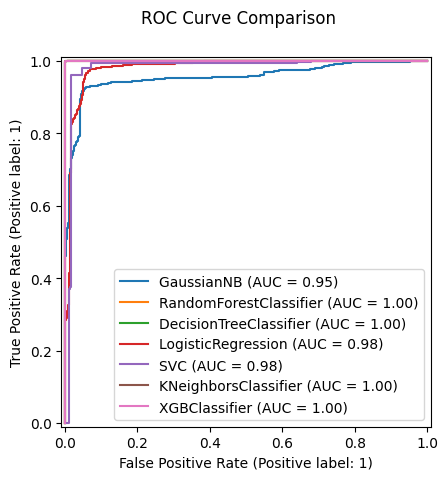

In [44]:
# plotting ROC curves with AUC scores
fig = plt.figure(figsize=(10, 5), dpi=300)
fig = RocCurveDisplay.from_estimator(nb, X_test, y_test)
fig = RocCurveDisplay.from_estimator(rf, X_test, y_test, ax = fig.ax_)
fig = RocCurveDisplay.from_estimator(dt, X_test, y_test, ax = fig.ax_)
fig = RocCurveDisplay.from_estimator(lr, X_test, y_test, ax = fig.ax_)
fig = RocCurveDisplay.from_estimator(svc, X_test, y_test, ax = fig.ax_)
fig = RocCurveDisplay.from_estimator(knn, X_test, y_test, ax = fig.ax_)
fig = RocCurveDisplay.from_estimator(xgboost, X_test, y_test, ax = fig.ax_)
fig.figure_.suptitle("ROC Curve Comparison")
plt.show()

## Обсуждение и заключение

В этом проекте наша цель - найти наилучший из возможных алгоритмов, который классифицирует грибы как съедобные или ядовитые. Мы использовали 7 алгоритмов и оценили их эффективность. Теперь мы обсудим несколько оценочных показателей, чтобы определить наилучший алгоритм, который следует использовать для прогнозирования классификации грибов. Но сначала немного терминологии! Большинство показателей оценки определяются в терминах положительных и отрицательных значений, как показано в матрицах путаницы. В нашей матрице путаницы для задачи бинарной классификации положительное значение определяется как 1, что соответствует ядовитым грибам. Следовательно, отрицательный класс соответствует 0, то есть съедобным грибам. Это говорит нам о том, что наши модели определяют, какие грибы являются ядовитыми (что является гипотезой), а не наоборот. Поэтому, прежде чем мы определим показатели оценки, рассмотрим еще несколько терминов:

- TP (истинные положительные результаты): сколько точек данных были правильно классифицированы как ядовитые (фактические = "p", прогнозируемые = "p").
- FP (ложноположительные результаты): сколько точек данных были ошибочно классифицированы как ядовитые (фактические = "e", прогнозируемые = "p").
- FN (Ложноотрицательные значения): сколько точек данных было неправильно классифицировано как съедобные (фактические = "p", прогнозируемые = "e").
- TN (истинные отрицательные значения): сколько точек данных было правильно классифицировано как съедобные (фактические = "e", прогнозируемые = "e").

**Точность**
Точность определяется следующим образом: $\frac{TP+TN}{TP+TN+FP+FN}$

- Показатель точности хорош для сбалансированного набора данных (который у нас есть) и для случаев, когда важен каждый класс.

**Точность**
Точность определяется следующим образом: $\frac{TP}{TP+FP}$

- Показатель точности хорош для измерения того, насколько часто класс "p" действительно классифицируется как класс "p", т.е. максимизируется по TPs. 
- В нашем случае это хороший показатель для сравнения наших моделей, поскольку нам нужно правильно предсказать, что ядовитые грибы являются ядовитыми, а не съедобными, поскольку это может привести к плохим последствиям для людей!

**Напомним**
Отзыв определяется следующим образом: $\frac{TP}{TP+FN}$

- Показатель отзыва хорош для измерения того, насколько часто класс "e" действительно классифицируется как класс "e", т.е. для максимизации TNS.
- Это также хороший показатель для сравнения наших моделей, поскольку мы также хотим правильно классифицировать съедобные грибы!

**Оценка F1**
Оценка F1 определяется следующим образом: $2\times \frac{точность\times recall}{точность + recall}$

- Показатель F1 называется "средним гармоническим значением между точностью и запоминаемостью". 
- Это означает, что он является хорошим показателем для определения того, как часто съедобные и ядовитые грибы правильно классифицируются.

**Показатель ROC/AUC**
- Кривая ROC (рабочая характеристика приемника) представляет собой график зависимости скорости передачи данных от скорости передачи данных FP.
- Показатель AUC (площадь под кривой) является показателем площади под кривой ROC.
- Показатель ROC/AUC хорош для измерения вероятности правильных прогнозов, сделанных как для съедобных, так и для ядовитых грибов.


Рассмотрев все эти показатели, мы определим наш основной показатель как точность, поскольку мы заинтересованы в том, чтобы свести к минимуму вероятность употребления ядовитых грибов, что произойдет только в том случае, если большинство ядовитых образцов в наборе данных будут правильно классифицированы.

Еще одна вещь, прежде чем мы начнем оценивать наши модели, - мы отмечаем, что несколько алгоритмов обеспечили 100%-ный результат по каждой метрике. Это показывает, что эти модели, скорее всего, были переоборудованы, т.е. модель усвоила определенные правила из обучающих данных и смогла применить их к тестовому набору данных как есть. Мы не будем учитывать эти усовершенствованные модели (случайный лес, Дерево решений, K-ближайших соседей и XGBoost) для окончательной оценки.

Итак, теперь у нас достаточно информации, чтобы приступить к оценке наших моделей. Давайте еще раз посмотрим на таблицу показателей производительности, после того как отфильтруем переоборудованные модели на основе точности.

In [45]:
performance_metrics[performance_metrics['accuracy']!=1].sort_values('precision', ascending=False)

,method,accuracy,precision,recall,f1,roc_auc
5,KNN,0.996308,0.992386,1.000000,0.996178,0.996441
4,SVC,0.972923,0.981723,0.961637,0.971576,0.972515
3,Logistic Regression,0.947077,0.942748,0.947570,0.945153,0.947095
0,Naive Bayes,0.921846,0.909887,0.929668,0.919671,0.922129


Основываясь на нашем основном показателе, точности, мы обнаружили, что модель KNN показала наилучшие результаты, за ней следует SVC (линейное ядро), за которым следует логистическая регрессия. Наименее точной моделью была модель наивного Байеса. Модель KNN обеспечила точность 99%, модель SVC - 98%, логистическая регрессия - 94% и, наконец, наивный метод Байеса - 90%. Это означает, что модель KNN классифицировала 99% всех ядовитых грибов как ядовитые.

Мы обнаруживаем, что другие показатели также имеют сходные показатели, при этом KNN показывает наилучшие результаты, за ним следует SVC, затем логистическая регрессия, затем наивный Байесовский анализ. Однако, с точки зрения запоминания, мы обнаруживаем, что KNN имеет 100%-ную память, что показывает, что он правильно классифицировал 100% съедобных грибов как съедобные. Интересно!

**Основываясь на проведенном обширном анализе и сравнении показателей, мы пришли к выводу, что для классификации этого набора данных следует использовать алгоритм K-ближайших соседей или модель классификатора опорных векторов.**

Итак, каковы же признаки, которые делают грибы ядовитыми? Согласно модели SVC, основными признаками, по которым гриб может быть ядовитым, являются цвет его покровов, размер жабр, кровоподтеки и тип колец**. Признаки, которые внесли наименьший вклад в классификацию, включают расстояние между жабрами, корень стебля, форму стебля, крепление жабр и количество колец, и это лишь некоторые из них.

Поэтому, чтобы завершить этот анализ, если бы у меня был с собой алгоритм, когда я был в лесу, исследуя грибы, который подсказывал бы мне вероятность того, что гриб ядовитый или нет, я бы выбрал либо алгоритм KNN, либо алгоритм SVC. Я бы также обратил пристальное внимание на цвет вуали, размер жабр, синяки и тип колец у грибов, чтобы подтвердить предсказания алгоритма.